# Introduction

The Pacific Crest Trail (PCT) is a 2650 mile trail that stretches from Mexico to Canada, passing through California, Oregon, and Washington.Thousands of hikers use the trail each year, hiking either smaller sections (section hikers) or the entire thing (through hikers). No matter the distance covered, hiking the PCT requires a lot of logistics planning, including determining daily distances, identifying resupply options, and choosing where to (legally) camp.

This notebook guides you, the user, through the process of doing some PCT planning. You can input GPS coordinates of their desired start/end points and their direction of travel ("north" vs. "south"), and the application will spit out the trail distance covered, teach you how to make an elevation profile, and and provide some information about resupply options on that section of the trail.

# Import Modules

The following code block imports the modules needed for the analysis.

In [1]:
import pandas as pd
import os
import re
import geopandas as gpd
import sys

The following codeblock connects to ArcGIS Online. You need to change the AGOL username, and also potentially the system path, depending on where ArcPy is installed on your computer. You should get an outpute of "GIS @ https://www.arcgis.com/" once the cell stops running.

In [125]:
usernameAGOL = 'gcs5243_pennstate'

os.environ["PATH"] = r"{};{}".format(os.environ["PATH"], r"C:\Program Files\ArcGIS\Pro\bin") # path has to be updated if you have installed Pro in a different location
sys.path.append(r"C:\Program Files\ArcGIS\Pro\Resources\ArcPy")                              # path has to be updated if you have installed Pro in a different location

import arcgis
from arcgis.gis import GIS
import arcpy

# connect to AGOL using ArcGIS Pro connection
gis = GIS('pro') 
gis

GIS @ https://www.arcgis.com/ version:9.4

# User Inputs

Set your workspace. The Pacific Crest Trail Shapefile, originally accessed through the PCTA, has been cleaned up. It was provided alongside this notebook.

In [3]:
arcpy.env.overwriteOutput = True
arcpy.env.workspace = r"C:\Users\grace\OneDrive\Documents\1_PSU\GEOG489\FinalProject"

Below, please enter the coordinates (latitude and longitude) of your desired start and end points. These should be in degrees. Also, please enter your direction of travel: "north" or "south", and note whether either your start or end point is at one of the termini.

In [13]:
pctFC = arcpy.env.workspace + "\PCT_Clean.shp"
# coordinates should be using WGS84
startLat = 45.467863
startLon = -121.829393
endLat = 45.7035928
endLon = -122.0007790
direction = "north" # "north" or "south"
startTerminus = False # True or False
endTerminus = False  # True or False

# Create Pointfile of Start and End Points

Given your input start and end points, the next step is to create a pointfile containing these points and save it to your workspace.

In [14]:
startPoint = (startLon, startLat)
endPoint = (endLon, endLat)

In [15]:
# create empty point feature class
arcpy.CreateFeatureclass_management(arcpy.env.workspace,"PlanningPoints.shp","POINT", "", "", "", arcpy.SpatialReference(4326))

# add field to hold start vs. end
arcpy.AddField_management("PlanningPoints.shp", "Type", "TEXT")

# create Insert Cursor
pointsCursor = arcpy.da.InsertCursor("PlanningPoints.shp", ["Shape@", "Type"])

pointsCursor.insertRow([startPoint, "start"]) #add start point
pointsCursor.insertRow([endPoint, "end"]) #add end point

del pointsCursor

# Reproject and Format Layers

In the next cell, we reproject the two layers to an equidistant projection, since we will be calculating distance.

We also dissolve the PCT layer so that it's a single feature. This will allow us to later extract just the portion between the start and end points.

In [16]:
# reproject to equidistant projection
arcpy.management.Project(pctFC, "pctFC_proj.shp", arcpy.SpatialReference(102005))
arcpy.management.Project("PlanningPoints.shp", "PlanningPoints_proj.shp", arcpy.SpatialReference(102005))

# dissolve pct FC to be single feature
arcpy.management.Dissolve("pctFC_proj.shp", "pctFC_dissolve.shp");

# clean up interim layers
arcpy.management.Delete("PlanningPoints.shp");

# Check Input Points

The following code checks the start and end points that the you gave to see if they are within 5 km of the trail. If they are, the points are updated to be directly on the trail (using the closest possible point). If a point is farther than 5 km from the trail, you will be asked to provide a new point.

In [17]:
# check how close input points are to PCT Line
arcpy.Near_analysis("PlanningPoints_proj.shp", "pctFC_dissolve.shp", "", "LOCATION")

updatedPoints = [] # empty list to hold update point info
tracker = 0 # track if points met the criteria
with arcpy.da.SearchCursor("PlanningPoints_proj.shp", ["Type", "NEAR_DIST", "NEAR_X", "NEAR_Y"]) as nearCursor:
    for row in nearCursor:
        if row[1] > 5000: # check to see if point is within 5 km of the trail
            print(row[0] + " point is too far from the PCT. Please enter a new point.")
        else: # if point is close enough, create new closest point directly on the trail
            newPoint = [(row[2], row[3]), "new_" + row[0]]
            updatedPoints.append(newPoint)
            tracker += 1

if tracker == 2: # if two new points were successfully created, move on
    print("Both points are good - move on to the next step!")

Both points are good - move on to the next step!


If any error message was thrown in the previous step, be sure to update the erroneous point, and then run all of the code cells again. Once you recieve the all clear, you can move forward. In the next step, you will add the updated points (snapped directly only the PCT path) to the pointfile.

In [18]:
# create Update Cursor to get rid of old points
with arcpy.da.UpdateCursor("PlanningPoints_proj.shp", ["Type"]) as updateCursor:
    for row in updateCursor:
        if row[0] == "start" or row[0] == "end":
            updateCursor.deleteRow()

del updateCursor

# create Insert Cursor to add in new points
newPointsCursor = arcpy.da.InsertCursor("PlanningPoints_proj.shp", ["Shape@", "Type"])
        
for point in updatedPoints:
    newPointsCursor.insertRow(point) #add updated points
del newPointsCursor

# Extract PCT Segment of Interest

The new bit of code splits the PCT line at our two points of interest, and then calculates the length of the line between these two points.


In [19]:
# split the pct line at the two defined points
arcpy.management.SplitLineAtPoint("pctFC_dissolve.shp", "PlanningPoints_proj.shp", "pctFC_split", "1 Meters")

# check for edge cases if one point was at a trail terminus
# if so, there will only be two segments, not three
featureCount = arcpy.management.GetCount("pctFC_split.shp")[0]

whereClause = ""

if featureCount == '3':
    whereClause = "FID" + ' = 1'  # get the middle feature

elif featureCount == '2': # only two segments because one of the points is at the terminus
    #check if point is at the Mexican border
    if (direction == "north" and startTerminus == True) or (direction == "south" and endTerminus == True):
        
        whereClause = "FID" + ' = 0' # get first feature (further south)
    #else assume point is at the Canadian border
    else:
        whereClause = "FID" + ' = 1' # get first feature (further north)
else:
    print("Something went wrong. Please try different points")
    
        
print(whereClause)

FID = 1


In [21]:
# select PCT segment based on where clause
pctSegment = arcpy.SelectLayerByAttribute_management("pctFC_split.shp", "NEW_SELECTION", whereClause)

# copy selected features to new shapefile
arcpy.CopyFeatures_management(pctSegment, "pctSegment.shp");

# calculate geometry of feature
arcpy.management.CalculateGeometryAttributes("pctSegment.shp", [["Distance", "LENGTH"]], "MILES (UNITED STATES)")

with arcpy.da.SearchCursor("pctSegment.shp", ["Distance"]) as searchCursor:
    for row in searchCursor:
        print("Total Distance from start to end point: " + str(round(row[0], 2)) + " miles.")

del searchCursor

Total Distance from start to end point: 36.05 miles.


# Create Elevation Profile

In this next part, we use the output PCT segment that we just extracted to create an elevation profile. This will allow you to get more information about this section of your hike.

Unfortunately, this feature is not available through Arcpy, and so has to be done directly within ArcGIS Pro.

To create an elevation profile, load your PCT segment file into ArcGIS Pro, and then go to Ready To Use Tools, and Select "Profile" (see below). This tool is available through ArcGIS Online.

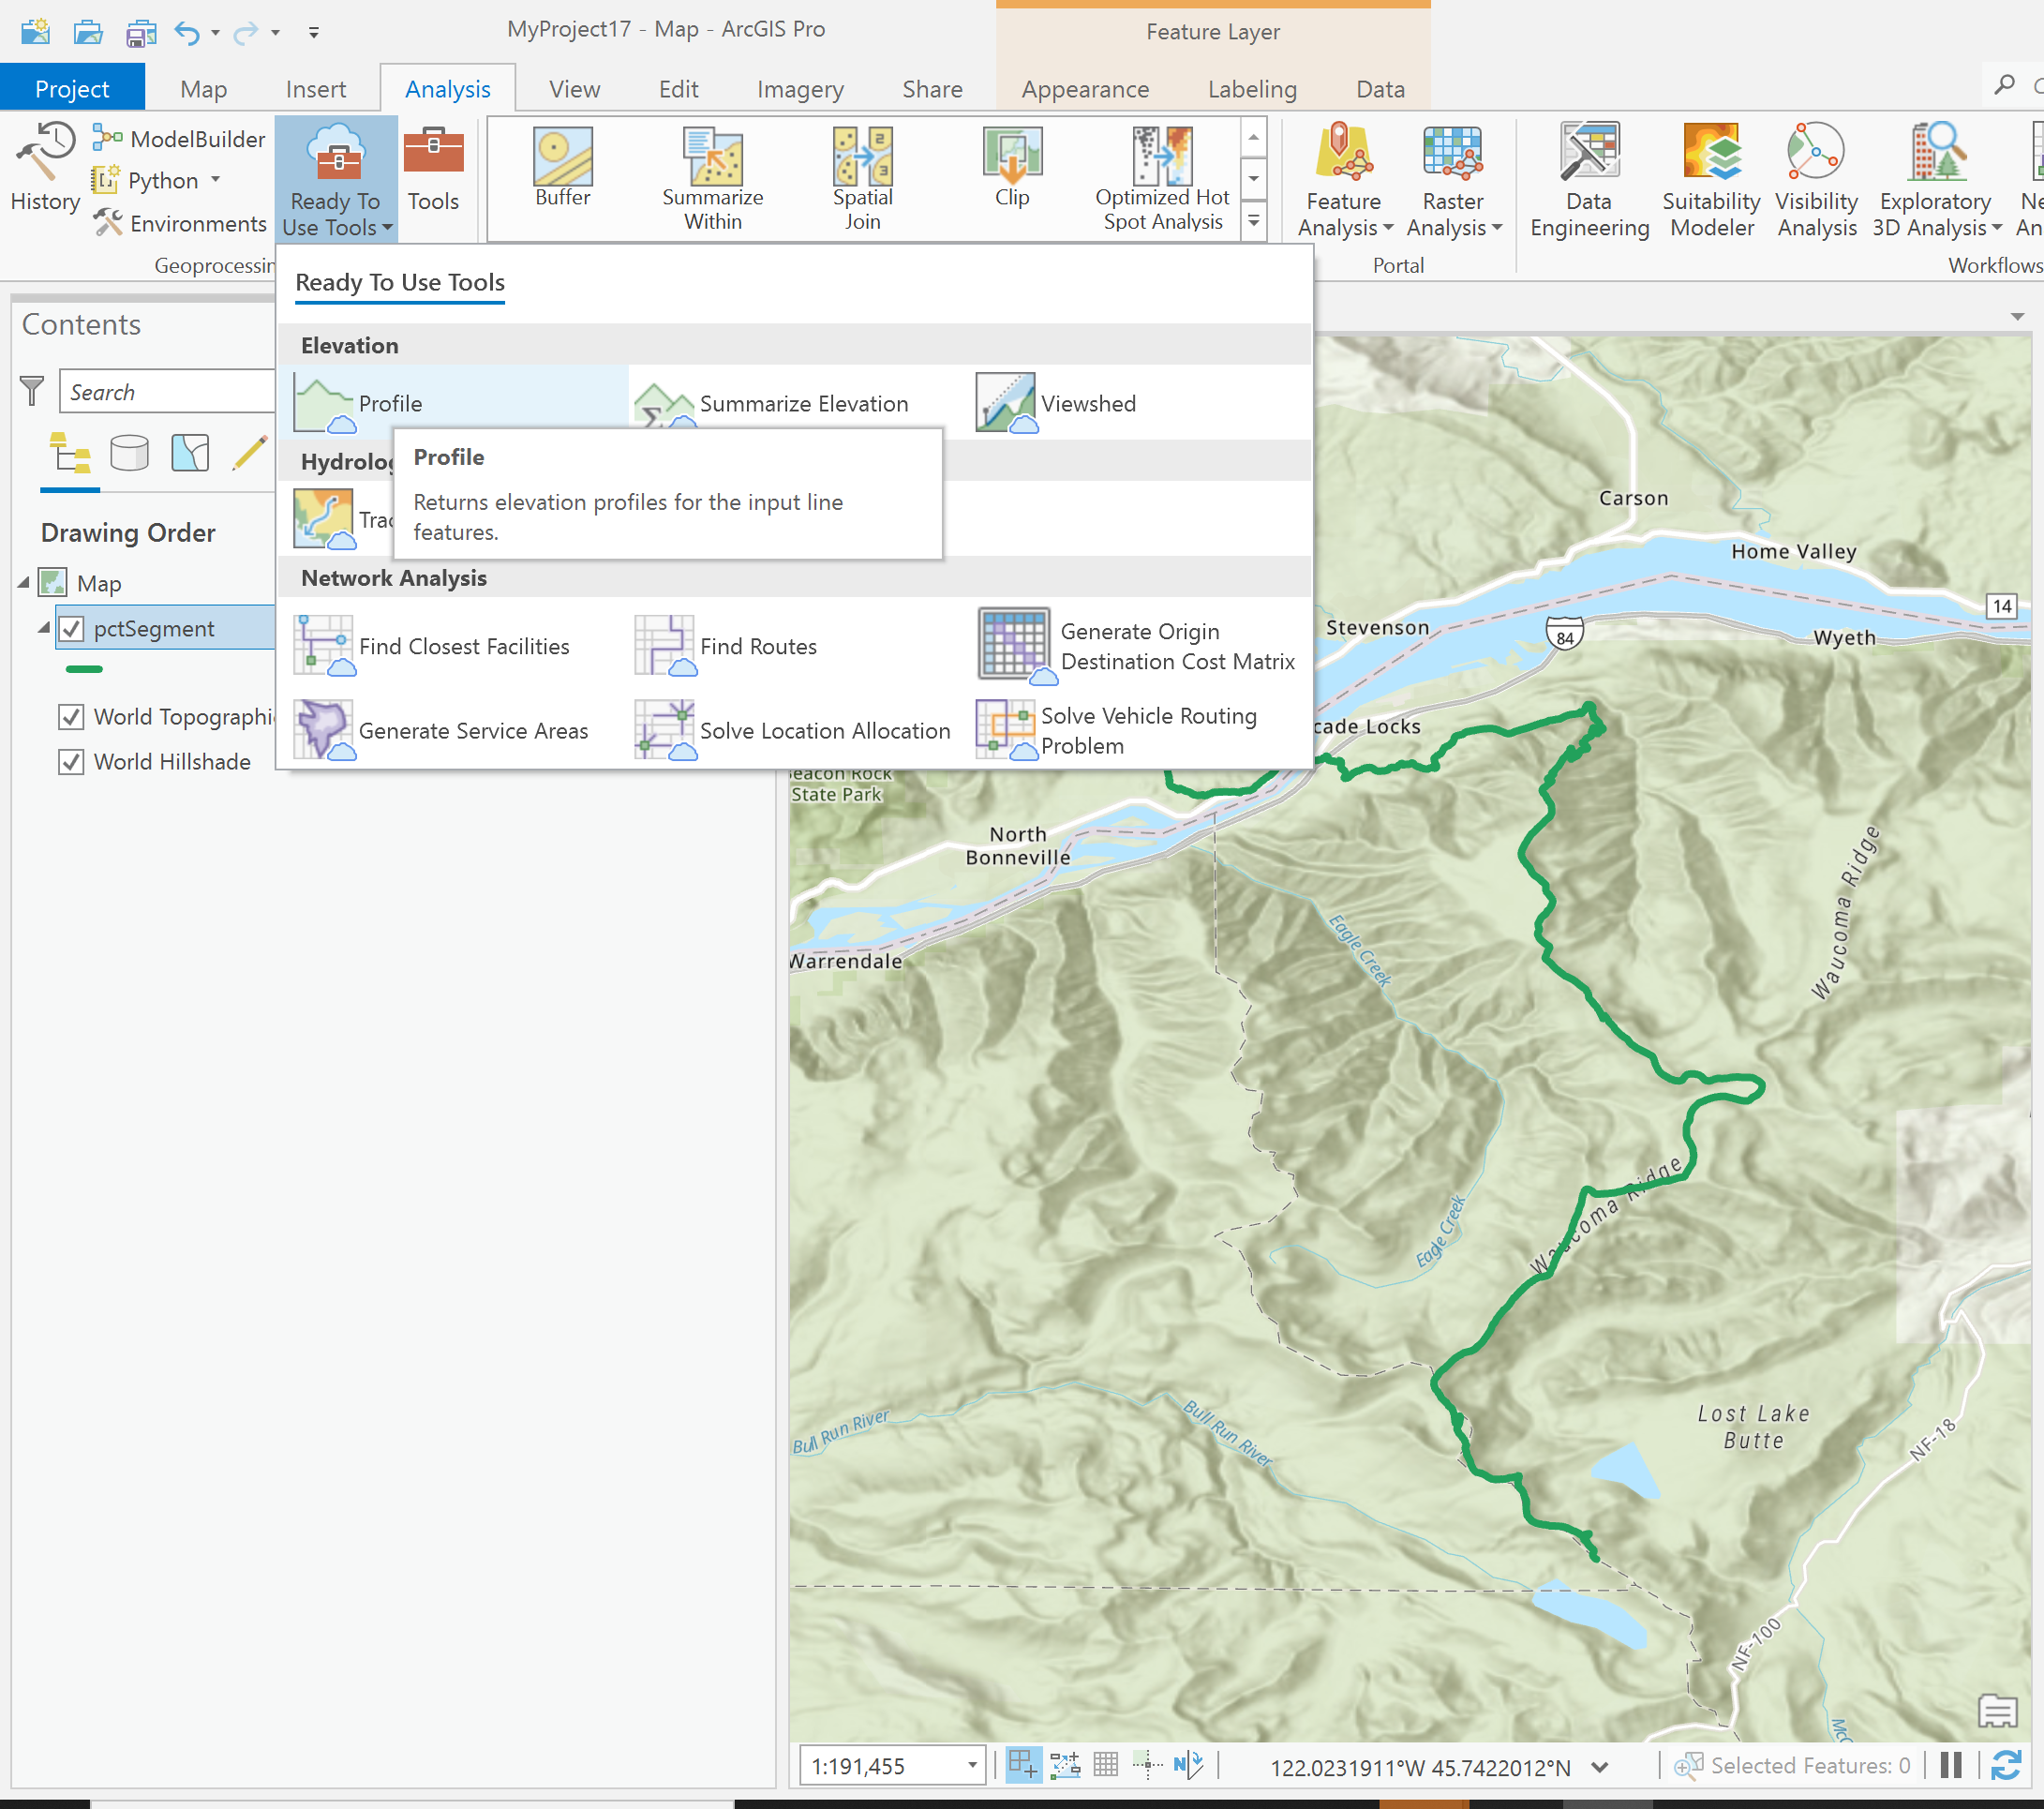

This will open up a parameters window, where you should select your PCT segment shapefile as the input line layer, and choose your resolution. For our purposes, 30 m is sufficient. You can leave the remaining fields blank, and the tool will determine the most appropriate number of vertices to sample elevation at.

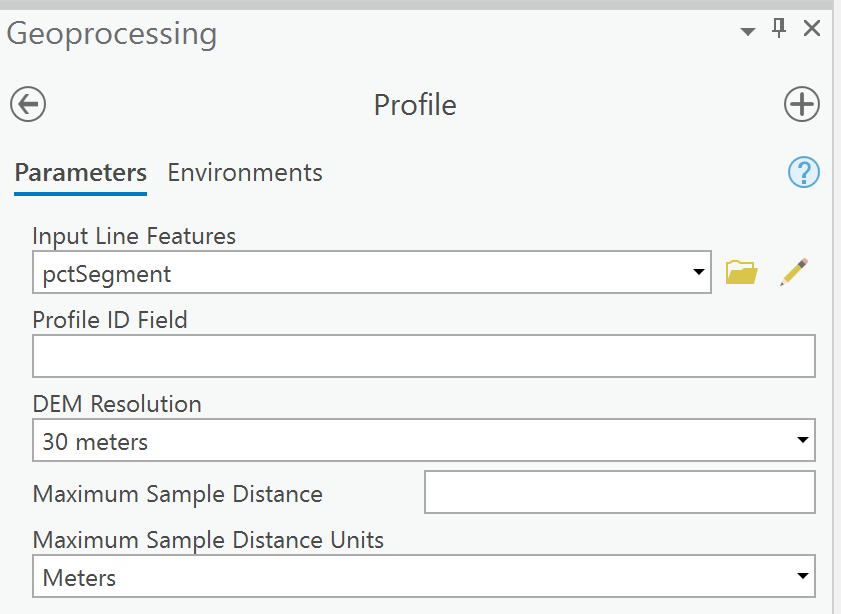

The output will be a layer called "Output Profile". Right Click on this layer, look for "Charts", and then select "Profile Graph" from the bottom.

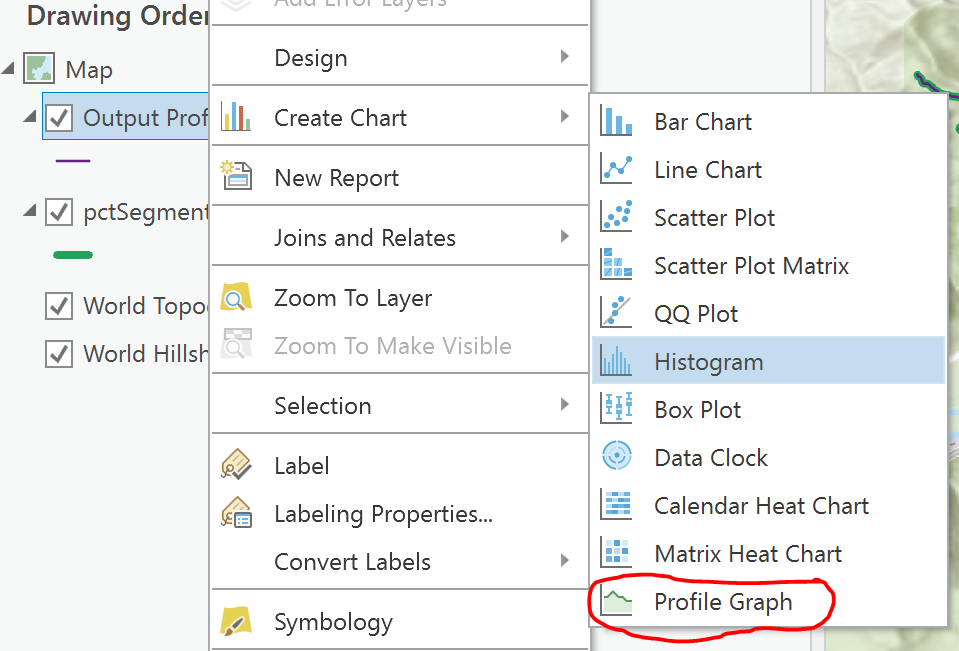

You'll then have the option to customize labels and units, and a chart will appear within your ArcGIS window:

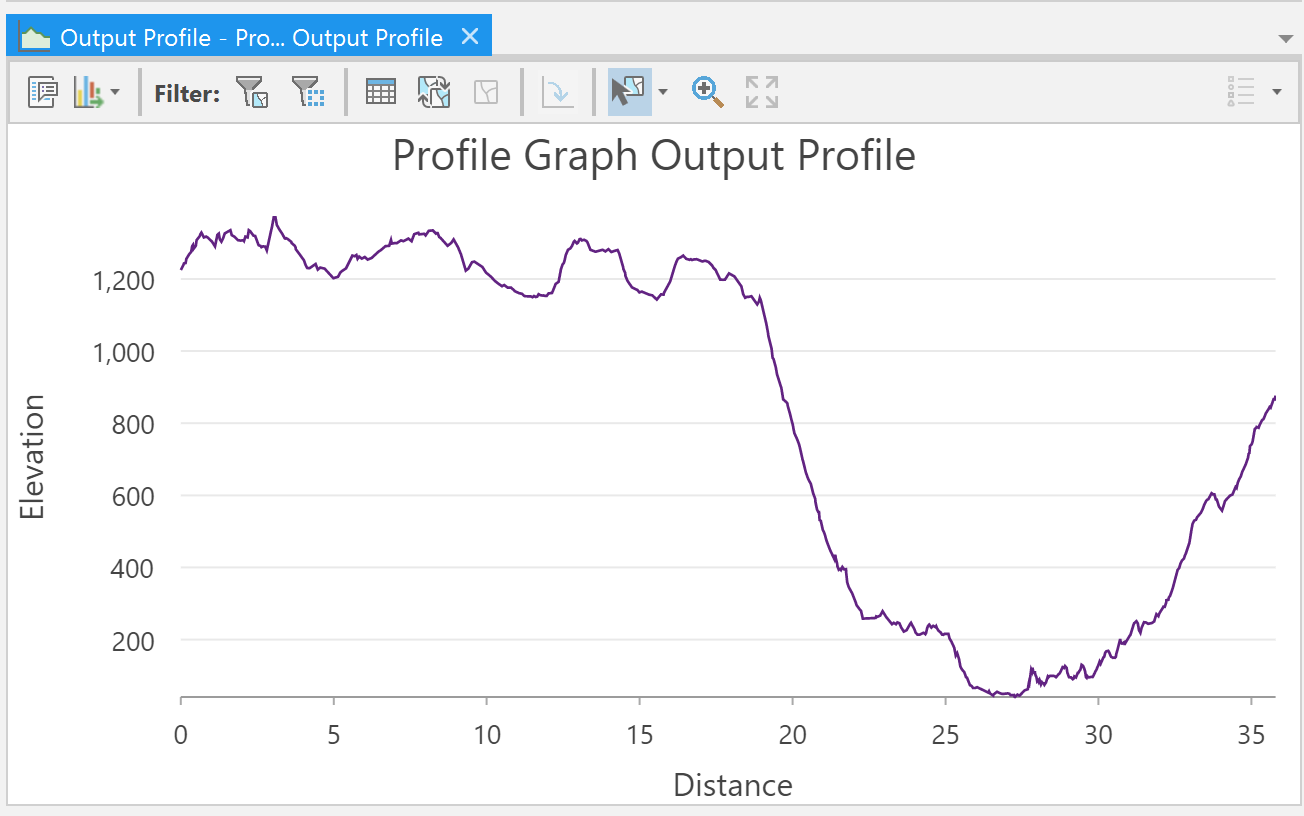

# Identify Resupply Options

Getting into towns to resupply is a crucial part of a successful hike. In this next section, we'll examine the trail town resupply feature service, hosted by the PCTA.

In [77]:
# import resupply town layer from ArcGIS Server
resupplyTownsURL  = r'https://services5.arcgis.com/ZldHa25efPFpMmfB/arcgis/rest/services/Trail_Town_Resupply_Public/FeatureServer/0'
arcpy.MakeFeatureLayer_management(resupplyTownsURL, "ResupplyTownsFL");

To get a general overview of this layer, we'll count the number of resupply towns in each state, and create a bar chart using matplotlib.

In [72]:
caCounter = 0
orCounter = 0
waCounter = 0

with arcpy.da.SearchCursor("ResupplyTownsFL", ["Location", "State"]) as cursor:
    for row in cursor:
        if row[1] == 'CA':
            caCounter += 1
        elif row[1] == 'OR':
            orCounter += 1
        else:
            waCounter += 1

townData = [caCounter,orCounter,waCounter]


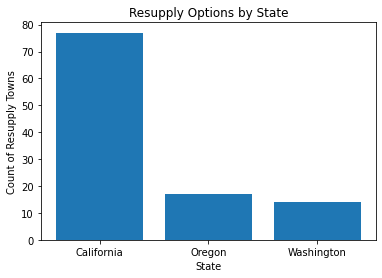

In [76]:
import matplotlib.pyplot as plt

plt.bar(["California", "Oregon", "Washington"], townData)
plt.xlabel('State')
plt.ylabel('Count of Resupply Towns')
plt.title('Resupply Options by State')
plt.show()

Finally, we'll extract the towns that fall within 10 Miles of the PCT (as the crow flies), and create a new shapefile with these towns.

In [124]:
# select towns within 10 miles of the PCT
nearbyTowns = arcpy.management.SelectLayerByLocation("ResupplyTownsFL", "WITHIN_A_DISTANCE", "pctSegment.shp", "10 Miles", "NEW_SELECTION");

# copy towns to new feature layer
arcpy.CopyFeatures_management(nearbyTowns, "nearbyTowns.shp");

# count number of towns in new layer
townCount = arcpy.management.GetCount("nearbyTowns.shp")[0]

townList = []

with arcpy.da.SearchCursor("nearbyTowns.shp", ["Location", "State"]) as townCursor:
    for row in townCursor:
        townList.append(row)

del townCursor

print("There are " + str(townCount) + " towns within 10 miles of your section of the PCT:" + str(townList))

There are 2 towns within 10 miles of your section of the PCT:[('Cascade Locks', 'OR'), ('Stevenson', 'WA')]


# Putting it all on a map

The last step in this process is visualizing this section of the PCT, your start and end points, and nearby trail towns. To do this, we'll use the connect to ArcGIS Online that we created above.

To view our layers on map, we'll need to upload them to ArcGIS Online. We will upload the following layers: PlanningPoints_proj.shp, PCT_Clean.shp, pctSegment.shp, and nearbyTowns.shp.

To avoid errors, we'll first check that none of these files already exist in our account.

In [83]:
# this code is modified from lesson 3
# search for content in your gis with a query built from tit,e, owner and item type
def searchAGOL(title, owner, itemType):
    return gis.content.search(query='title:'+title+' owner:'+owner, item_type=itemType)

# test whether items exist on AGOL for given title, owner, and item type and if so, delete them from AGOL
def deleteIfExistsOnAGOL(title, owner, itemType):
    result = searchAGOL(title, owner, itemType)   # search item
    print('Found items for title='+title+', owner='+owner+', itemType='+itemType+':')
    print(result)
    for item in result:                           # delete items found
        item.delete()
        print('Item ' + item.title + ' has been deleted.')

filesOfInterest = ['PlanningPoints_proj', 'PCT_Clean', 'pctSegment','nearbyTowns']    
for file in filesOfInterest:
    deleteIfExistsOnAGOL(file + '.shp', usernameAGOL, 'Shapefile')

Found items for title=PlanningPoints_proj.shp, owner=gcs5243_pennstate, itemType=Shapefile:
[]
Found items for title=PCT_Clean.shp, owner=gcs5243_pennstate, itemType=Shapefile:
[]
Found items for title=pctSegment.shp, owner=gcs5243_pennstate, itemType=Shapefile:
[]
Found items for title=nearbyTowns.shp, owner=gcs5243_pennstate, itemType=Shapefile:
[]


If all of the "found items" lists come up empty, then we're good to upload the files. First, we have to zip the shapefiles.

In [84]:
import zipfile
inputFolder = arcpy.env.workspace
# function to create zipped shapefile for a given filename without extension
def zipShapefile(name):
    compiledRE = re.compile(name+'(?!.zip)\....$')
    with zipfile.ZipFile( os.path.join(inputFolder, name + '.zip'), 'w', zipfile.ZIP_DEFLATED) as zf:  # create zipfile
        for file in os.listdir(inputFolder):                                                           # go through files in workspace
            if compiledRE.match(file):                                                               # test whether file is part of the shapefile to be zipped
                zf.write(os.path.join(inputFolder,file),file,zipfile.ZIP_DEFLATED)                     # add file to zipfile
                
# create zipped version of observation shapefile
for file in filesOfInterest:
    zipShapefile(file)

Then, we upload the shapefiles:

In [87]:
PlanningPointsAGOL = gis.content.add({'type':'Shapefile'}, inputFolder + '\PlanningPoints_proj.zip')
PCT_CleanAGOL = gis.content.add({'type':'Shapefile'}, inputFolder + '\PCT_Clean.zip')
pctSegmentAGOL = gis.content.add({'type':'Shapefile'}, inputFolder + '\pctSegment.zip')
nearbyTownsAGOL = gis.content.add({'type':'Shapefile'}, inputFolder + '\\nearbyTowns.zip')

In [90]:
# check for success
print(searchAGOL('PlanningPoints_proj', usernameAGOL, 'Shapefile'))
print(searchAGOL('PCT_Clean', usernameAGOL, 'Shapefile'))
print(searchAGOL('pctSegment', usernameAGOL, 'Shapefile'))
print(searchAGOL('nearbyTowns', usernameAGOL, 'Shapefile'))

[<Item title:"PlanningPoints_proj" type:Shapefile owner:gcs5243_pennstate>]
[<Item title:"PCT_Clean" type:Shapefile owner:gcs5243_pennstate>]
[<Item title:"pctSegment" type:Shapefile owner:gcs5243_pennstate>]
[<Item title:"nearbyTowns" type:Shapefile owner:gcs5243_pennstate>]


Finally, we published the shapefiles as a feature service within AGOL, and again check that this process was successful:

In [91]:
PlanningPointsAGOLFS = PlanningPointsAGOL.publish()
PCT_CleanAGOLFS = PCT_CleanAGOL.publish()
pctSegmentAGOLFS = pctSegmentAGOL.publish()
nearbyTownsAGOLFS = nearbyTownsAGOL.publish()

In [92]:
# check for success
print(searchAGOL('PlanningPoints_proj', usernameAGOL, 'Feature Service'))
print(searchAGOL('PCT_Clean', usernameAGOL, 'Feature Service'))
print(searchAGOL('pctSegment', usernameAGOL, 'Feature Service'))
print(searchAGOL('nearbyTowns', usernameAGOL, 'Feature Service'))

[<Item title:"PlanningPoints_proj" type:Feature Layer Collection owner:gcs5243_pennstate>]
[<Item title:"PCT_Clean" type:Feature Layer Collection owner:gcs5243_pennstate>]
[<Item title:"pctSegment" type:Feature Layer Collection owner:gcs5243_pennstate>]
[<Item title:"nearbyTowns" type:Feature Layer Collection owner:gcs5243_pennstate>]


Now it's time to actually see all of the work come together in one pplace. To view the layers, we'll use a map object from the gis module:

In [121]:
Map = gis.map()
Map.basemap = 'topographic'
Map.center = (startLat, startLon)
Map.zoom = 9

# create symbology for layers
segmentSymbol = {
    "type": "simple-line",
    "color": "yellow",
    "width": "5px",
    "opacity": ".3"
}

townSymbol = {
    "type": "simple-marker",
    "style": "circle",
    "color": "blue",
    "size": "7px"
} 

planningPointsSymbol = {
    "type": "simple-marker",
    "style": "x",
    "color": "red",
    "size": "10px",
    "outline": {
        "color": "red",
        "width": "3px"
}}

# Add all layers to map
Map.add_layer(PCT_CleanAGOLFS)
Map.add_layer(pctSegmentAGOLFS, {"renderer": "autocast",
                                "type" : "simple",
                                "symbol" : segmentSymbol})



Map.add_layer(nearbyTownsAGOLFS, {"renderer": "autocast",
                                "type" : "simple",
                                "symbol" : townSymbol})

Map.add_layer(PlanningPointsAGOLFS,{"renderer": "autocast",
                                "type" : "simple",
                                "symbol" : planningPointsSymbol})
Map

MapView(layout=Layout(height='400px', width='100%'))

# Happy Hiking!
